<a href="https://colab.research.google.com/github/KalebAvila/Deep_Learning/blob/main/Proyecto_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Crear las carpetas para subir las imagenes
!mkdir Beis
!mkdir Beis/A
!mkdir Beis/B

In [ ]:
#Entrar en cada carpeta y descomprimir el archivo zip
!unzip /content/Beis/A/A.zip -d /content/Beis/A
!unzip /content/Beis/B/B.zip -d /content/Beis/B

Archive:  /content/Beis/A/A.zip
 extracting: /content/Beis/A/vector.svg  
 extracting: /content/Beis/A/vector2.svg  
 extracting: /content/Beis/A/vector3.svg  
 extracting: /content/Beis/A/vector4.svg  
 extracting: /content/Beis/A/vector5.svg  
 extracting: /content/Beis/A/vector6.svg  
 extracting: /content/Beis/A/vector7.svg  
 extracting: /content/Beis/A/vector8.svg  
 extracting: /content/Beis/A/vector9.svg  
 extracting: /content/Beis/A/vector10.svg  
 extracting: /content/Beis/A/vector11.svg  
 extracting: /content/Beis/A/vector12.svg  
 extracting: /content/Beis/A/image.jpeg  
 extracting: /content/Beis/A/image2.jpeg  
 extracting: /content/Beis/A/image3.jpeg  
 extracting: /content/Beis/A/image4.jpeg  
 extracting: /content/Beis/A/image5.jpeg  
 extracting: /content/Beis/A/image6.jpeg  
 extracting: /content/Beis/A/image7.jpeg  
 extracting: /content/Beis/A/image8.jpeg  
 extracting: /content/Beis/A/image9.jpeg  
 extracting: /content/Beis/A/image10.jpeg  
 extracting: /conten

In [ ]:
#Borrar los archivo ZIP para que no queden como basura
!rm -rf /content/Beis/B/B.zip
!rm -rf /content/Beis/A/A.zip

In [ ]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/Beis/A | wc -l
!ls /content/Beis/B | wc -l


131
121


Skipping non-image file: vector5.svg
Skipping non-image file: vector8.svg
Skipping non-image file: vector11.svg
Skipping non-image file: vector.svg


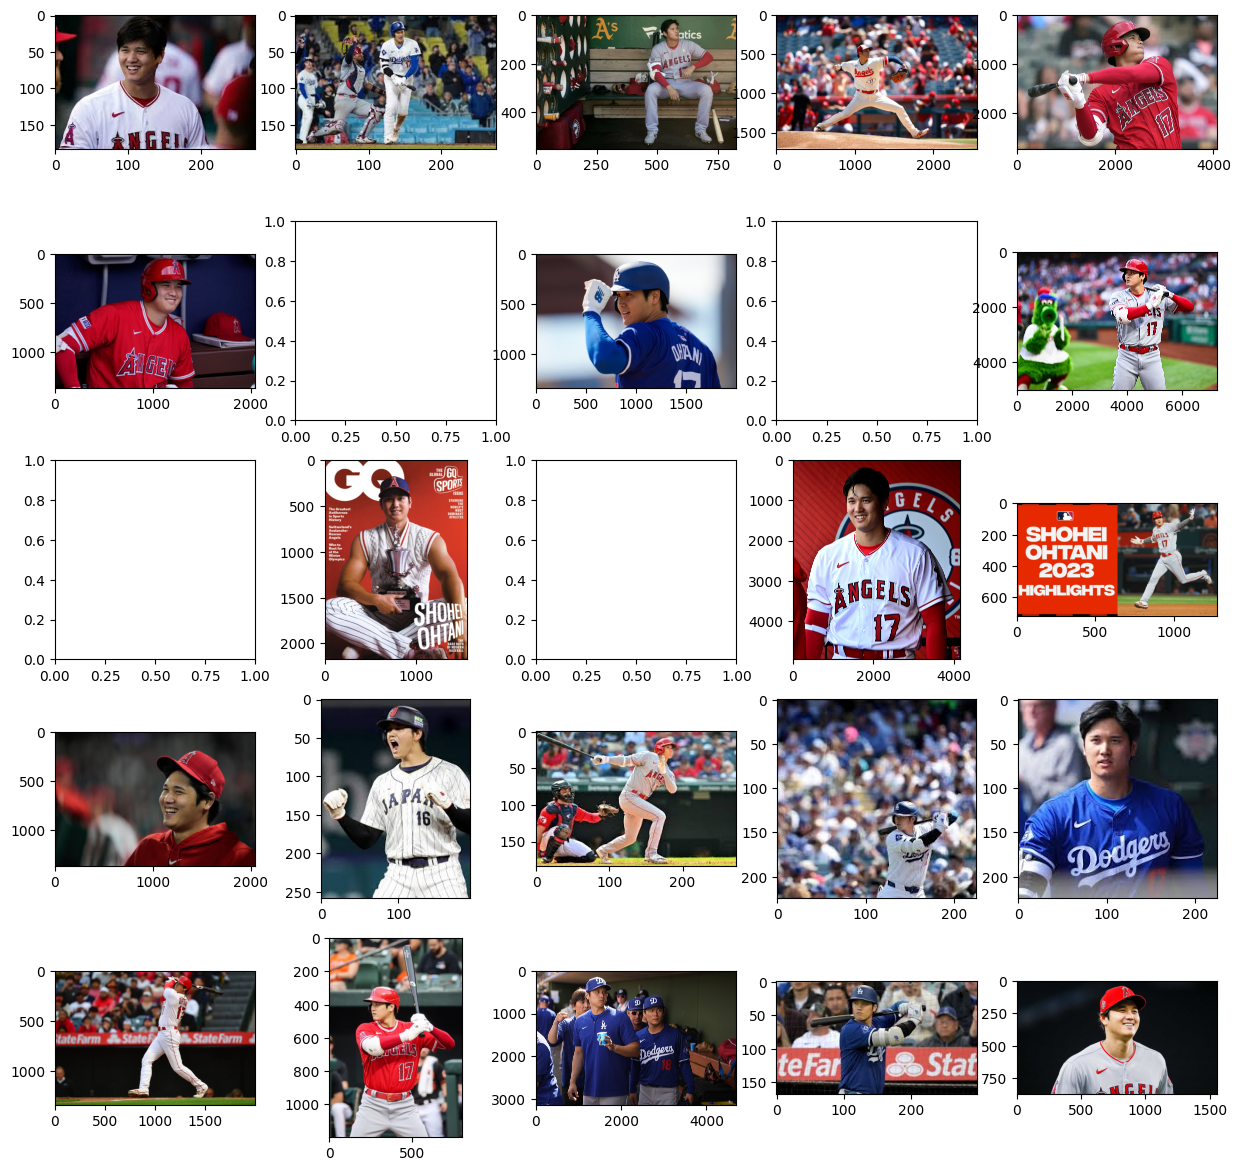

In [ ]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

plt.figure(figsize=(15,15))

carpeta = '/content/Beis/A'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  try:
    imagen = Image.open(carpeta + '/' + nombreimg)
    imagen = np.array(imagen)
    plt.imshow(imagen)
  except:
    print(f"Skipping non-image file: {nombreimg}")

SSIM: 0.14872561395168304, PSNR: 10.159250259399414


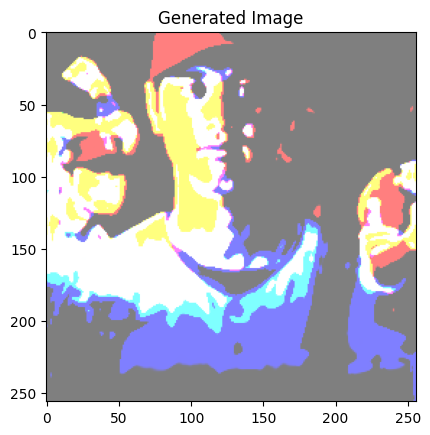

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from piq import ssim, psnr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Definición de los bloques básicos
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

# Definición del generador
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            # Aquí más capas si son necesarias...
        ]
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(64)]
        model += [
            nn.Conv2d(64, output_nc, kernel_size=7, padding=3),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Definición del discriminador
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Aquí más capas si son necesarias...
            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Configuración de transformaciones para tus imágenes
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instanciación de los modelos
netG_A2B = Generator(3, 3) # Asume que las imágenes tienen 3 canales
netG_B2A = Generator(3, 3)
netD_A = Discriminator(3)
netD_B = Discriminator(3)

# Función de pérdida y optimizador
criterion_GAN = nn.MSELoss()
criterion_identity = nn.L1Loss()
optimizer_G = torch.optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(list(netD_A.parameters()) + list(netD_B.parameters()), lr=0.002, betas=(0.5, 0.999))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG_A2B =  netG_A2B.to(device)
netG_A2B = netG_B2A.to(device)
netD_A = netD_A.to(device)
netD_B = netD_B.to(device)

# Configuración de transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize(256),  # Cambia el tamaño de las imágenes a 256x256
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar los datasets
dataset_A = datasets.ImageFolder(root='/content/Beis', transform=transform)
dataset_B = datasets.ImageFolder(root='/content/Beis', transform=transform)

# DataLoaders para cada dominio
dataloader_A = DataLoader(dataset_A, batch_size=1, shuffle=True)
dataloader_B = DataLoader(dataset_B, batch_size=1, shuffle=True)


# Iniciar bucle de entrenamiento
for epoch in range(20):  # Número de épocas
    for data_A, data_B in zip(dataloader_A, dataloader_B):
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # Generar imágenes falsas
        fake_B = netG_A2B(real_A)
        fake_A = netG_B2A(real_B)

        optimizer_D.zero_grad()

        # Discriminador A
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()

        # Discriminador B
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()

        optimizer_D.step()

        optimizer_G.zero_grad()

        # Generadores A2B y B2A
        # Pérdida adversarial
        pred_fake = netD_B(fake_B)
        loss_G_A2B = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
        pred_fake = netD_A(fake_A)
        loss_G_B2A = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Pérdida de identidad
        loss_identity_A = criterion_identity(netG_B2A(real_A), real_A) * 5.0
        loss_identity_B = criterion_identity(netG_A2B(real_B), real_B) * 5.0

        # Pérdida de ciclo
        recovered_A = netG_B2A(fake_B)
        recovered_B = netG_A2B(fake_A)
        loss_cycle_ABA = criterion_identity(recovered_A, real_A) * 10.0
        loss_cycle_BAB = criterion_identity(recovered_B, real_B) * 10.0

        # Pérdida total de generadores
        loss_G = loss_G_A2B + loss_G_B2A + loss_identity_A + loss_identity_B + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()

        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss_D: {(loss_D_A.item() + loss_D_B.item()) / 2}, Loss_G: {loss_G.item()}")

# Evaluación del modelo

def reescale_images(img):
    """ Reescala imágenes de [-1, 1] a [0, 1] """
    return (img + 1) / 2

# Ajustar las imagenes de rango de [0,1]
real_A_adjusted = reescale_images(real_A)
fake_B_adjusted = reescale_images(fake_B)

# Calcular SSIM y PSNR
ssim_value = ssim(real_A_adjusted, fake_B_adjusted)
psnr_value = psnr(real_A_adjusted, fake_B_adjusted)
print(f"SSIM: {ssim_value.item()}, PSNR: {psnr_value.item()}")


# Guardar y visualizar imágenes

# Reescalar y guardar la imagen
fake_B_rescaled = reescale_images(fake_B)
torchvision.utils.save_image(fake_B_rescaled.cpu(), 'output_image.png')

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # Clonar el tensor para no hacer cambios en el original
    image = image.squeeze(0)      # Reducir dimensiones si es necesario
    image = image.detach().numpy()  # Convertir a numpy
    image = np.transpose(image, (1, 2, 0))
    image = (image + 1) / 2
    image = np.clip(image, 0, 1)  # Asegurar que los valores estén entre 0 y 1
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

imshow(fake_B_rescaled, title='Generated Image')
